In [27]:
import gym
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from gym.envs.toy_text.frozen_lake import generate_random_map
from hiive.mdptoolbox.mdp import PolicyIteration, ValueIteration, QLearning, PolicyIterationModified
from hiive.mdptoolbox.example import forest

In [2]:
def run_episode(env, policy, gamma, render=True):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        obs, reward, done, _ = env.step(int(policy[obs]))
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward

In [3]:
def evaluate_policy(env, policy, gamma, n=500):
    scores = [run_episode(env, policy, gamma, False) for _ in range(n)]
    return np.mean(scores)

In [4]:

def extract_policy(env, v, gamma):
    policy = np.zeros(env.nS)
    for s in range(env.nS):
        q_sa = np.zeros(env.nA)
        for a in range(env.nA):
            q_sa[a] = sum([p * (r + gamma * v[s_]) for p, s_, r, _ in env.P[s][a]])
        policy[s] = np.argmax(q_sa)
    return policy

In [6]:
def colors_lake():
    return {
            b'S': 'green',
            b'F': 'skyblue',
            b'H': 'black',
            b'G': 'gold',
                 }

In [8]:
def directions_lake():
    return {
            3: '⬆',
            2: '➡',
            1: '⬇',
            0: '⬅'
        }

In [17]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True,render_mode="human")
env = env.unwrapped
env.action_space.seed(42)
#desc is used to specify custom map for frozen lake
desc = env.unwrapped.desc
print(desc)

[[b'S' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'H']
 [b'F' b'F' b'F' b'H']
 [b'H' b'F' b'F' b'G']]


In [32]:
observation, info = env.reset(seed=42)

for _ in range(10):
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    if True:
        env.render()
    if terminated or truncated:
        observation, info = env.reset()

env.close()

In [57]:

size = 4
map_ = generate_random_map(size=size, p=0.90)
env = gym.make("FrozenLake-v1", desc=map_, is_slippery = True,render_mode="human")
env.reset()

# print(env.desc)
states = env.observation_space.n
actions = env.action_space.n

trans = np.zeros((actions, states, states))
rewards = np.zeros((states, actions))
for state in range(states):
    for action in range(actions):
        for result in env.env.P[state][action]:
            next_state = result[1]
            prob = result[0]
            reward = result[2]
            trans[action][state][next_state] += prob
            rewards[state][action] += reward


/Users/labuser/miniconda3/envs/ml_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/labuser/miniconda3/envs/ml_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/labuser/miniconda3/envs/ml_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in a

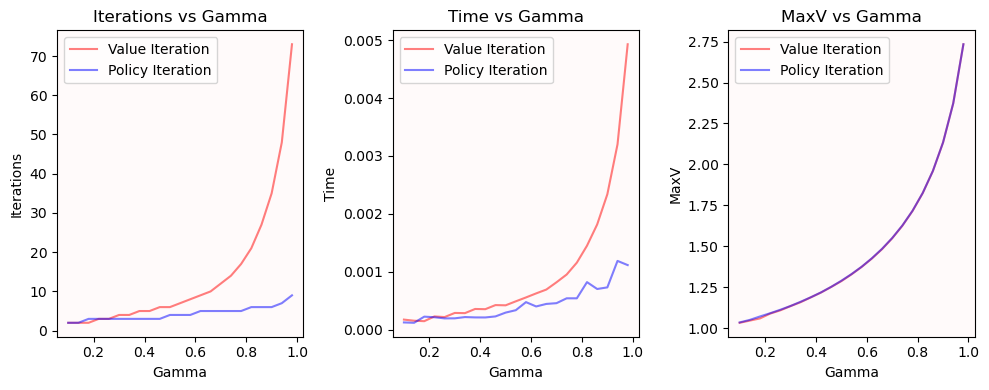

In [61]:
vistats = []
pistats = []
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,4));

gammas = np.arange(0.1, 0.99, 0.04)

for gamma in gammas:
    vi = ValueIteration(trans, rewards, gamma)
    vi.run()
    time = vi.time
    maxV = np.amax(vi.V)    
    iters = vi.iter
    vistats.append(['VI', size, gamma, time, maxV, iters])
    
    pi = PolicyIterationModified(trans, rewards, gamma)
    pi.run()
    time = pi.time
    maxV = np.amax(pi.V)    
    iters = pi.iter
    pistats.append(['PI', size, gamma, time, maxV, iters])
    
dfvi = pd.DataFrame(vistats, columns=['Type', 'Size', 'Gamma',  'Time', 'MaxV',  'Iterations'])
dfpi = pd.DataFrame(pistats, columns=['Type', 'Size', 'Gamma',  'Time', 'MaxV',  'Iterations'])

sns.lineplot(dfvi['Gamma'], dfvi['Iterations'], label = "Value Iteration", ax=axs[0], alpha=0.5, color='red')
sns.lineplot(dfpi['Gamma'], dfpi['Iterations'], label = "Policy Iteration", ax=axs[0], alpha=0.5, color='blue')

axs[0].set_title('Iterations vs Gamma')

sns.lineplot(dfvi['Gamma'], dfvi['Time'], label = "Value Iteration", ax=axs[1], alpha=0.5, color='red')
sns.lineplot(dfpi['Gamma'], dfpi['Time'], label = "Policy Iteration", ax=axs[1], alpha=0.5, color='blue')
axs[1].set_title('Time vs Gamma')

sns.lineplot(dfvi['Gamma'], dfvi['MaxV'], label = "Value Iteration", ax=axs[2], alpha=0.5, color='red')
sns.lineplot(dfpi['Gamma'], dfpi['MaxV'], label = "Policy Iteration", ax=axs[2], alpha=0.5, color='blue')
axs[2].set_title('MaxV vs Gamma')

for ax in axs.flat:
    ax.legend(loc='best')
    ax.set_facecolor("snow")
    
fig.tight_layout()
    